### Cell 1: Setup and Configuration
Purpose: To centralize all settings, file paths, and analysis parameters. This makes it easy to adjust the definition of an "active day" or the "risk threshold" without searching through the code.

In [1]:
# ==============================================================================
# CELL 1: SETUP AND CONFIGURATION
# ==============================================================================
import pandas as pd
import numpy as np

print("--- Cell 1: Initializing Configuration and Loading Libraries ---")

# Central dictionary for all settings, file paths, and constants.
CONFIG = {
    "input_csv_path": "00_cleaned_data.csv",
    "output_csv_path": "03_driver_risk_analysis.csv",
    "output_plot_path": "03_driver_risk_scores_distribution.png",
    "risk_params": {
        "active_day_threshold_km": 1.0,  # Min km for a day to be "active"
        "risk_z_score_threshold": -1.5   # Z-score threshold for "High Risk"
    }
}

print("Configuration loaded successfully.")

--- Cell 1: Initializing Configuration and Loading Libraries ---
Configuration loaded successfully.


### Cell 2: Data Loading and Data Health Pre-Check (Vectorized)
Purpose: To load the cleaned data and efficiently perform the crucial pre-check for data quality issues (stagnant GPS or battery). This refactored version replaces the for loop with fast, vectorized groupby().transform() and np.select operations.

In [2]:
# ==============================================================================
# CELL 2: DATA LOADING AND DATA HEALTH PRE-CHECK (VECTORIZED)
# ==============================================================================

print("\n--- Cell 2: Loading Data and Flagging Quality Issues ---")

# Load the data using the path from CONFIG
try:
    df = pd.read_csv(CONFIG["input_csv_path"], parse_dates=['timestamp'])
    print(f"Successfully loaded '{CONFIG['input_csv_path']}' with {len(df)} records.")
except FileNotFoundError:
    print(f"ERROR: File not found at {CONFIG['input_csv_path']}")
    df = pd.DataFrame()

if not df.empty:
    df.dropna(subset=['fixed_lat', 'fixed_long', 'fixed_bat'], inplace=True)
    df = df.sort_values(['vin', 'timestamp']).reset_index(drop=True)
    
    # --- 1. Vectorized Data Quality Check ---
    # Use transform('nunique') to count unique values for each VIN and broadcast the result.
    df['lat_nunique'] = df.groupby('vin')['fixed_lat'].transform('nunique')
    df['lon_nunique'] = df.groupby('vin')['fixed_long'].transform('nunique')
    df['bat_nunique'] = df.groupby('vin')['fixed_bat'].transform('nunique')
    
    # --- 2. Assign Issue Reasons using np.select for efficiency ---
    conditions = [
        ((df['lat_nunique'] == 1) & (df['lon_nunique'] == 1)), # Stationary GPS
        (df['bat_nunique'] == 1)                               # Stagnant Battery
    ]
    choices = ['Stationary or GPS Failure', 'Battery Signal Failure']
    df['issue_reason'] = np.select(conditions, choices, default=None)
    
    # --- 3. Create the 'Healthy' DataFrame ---
    # This excludes all vehicles with any identified issues.
    df_healthy = df[df['issue_reason'].isnull()].copy()
    
    # Clean up temporary helper columns
    df.drop(columns=['lat_nunique', 'lon_nunique', 'bat_nunique'], inplace=True)
    
    print(f"Flagged {df['issue_reason'].notna().sum()} records belonging to vehicles with data quality issues.")
    print(f"Created 'df_healthy' for analysis with {df_healthy['vin'].nunique()} healthy vehicles.")


--- Cell 2: Loading Data and Flagging Quality Issues ---
Successfully loaded '00_cleaned_data.csv' with 154116 records.
Flagged 6771 records belonging to vehicles with data quality issues.
Created 'df_healthy' for analysis with 1045 healthy vehicles.


### Cell 3: Risk Analysis on Healthy Vehicles (Vectorized)
Purpose: To perform the core risk analysis on the healthy vehicles. This cell calculates daily distances, computes the average daily distance for active days, and then uses a Z-score to determine a risk category for each vehicle. The slow geodesic calculation is the only part that uses .apply(); the rest is vectorized.

In [3]:
# ==============================================================================
# CELL 3: RISK ANALYSIS ON HEALTHY VEHICLES (Corrected)
# ==============================================================================
from geopy.distance import geodesic

if 'df_healthy' in locals() and not df_healthy.empty:
    print("\n--- Cell 3: Risk Analysis on Active & Healthy Vehicles ---")
    
    # --- 1. Calculate Distance Between Consecutive Points (Optimized) ---
    print("Calculating distances...")
    df_healthy['prev_lat'] = df_healthy.groupby('vin')['fixed_lat'].shift(1)
    df_healthy['prev_lon'] = df_healthy.groupby('vin')['fixed_long'].shift(1)
    
    distance_calc_df = df_healthy.dropna(subset=['prev_lat']).copy()
    # Check if there are any rows to calculate distance for
    if not distance_calc_df.empty:
        distances = distance_calc_df.apply(
            lambda row: geodesic((row['prev_lat'], row['prev_lon']), (row['fixed_lat'], row['fixed_long'])).km,
            axis=1
        )
        df_healthy['distance_km'] = distances
    else:
        df_healthy['distance_km'] = 0 # If no previous points, all distances are 0

    # --- THIS IS THE CORRECTED LINE ---
    # Instead of using inplace=True, we assign the result directly back to the column.
    df_healthy['distance_km'] = df_healthy['distance_km'].fillna(0)
    # ---------------------------------

    # --- 2. Calculate Average Daily Distance per Vehicle ---
    print("Aggregating to find average daily distance...")
    df_healthy['date'] = df_healthy['timestamp'].dt.date
    daily_distances = df_healthy.groupby(['vin', 'date'])['distance_km'].sum().reset_index()
    
    cfg_risk = CONFIG["risk_params"]
    active_days = daily_distances[daily_distances['distance_km'] > cfg_risk["active_day_threshold_km"]]
    
    if not active_days.empty:
        avg_daily_distance = active_days.groupby('vin')['distance_km'].mean().reset_index()
        avg_daily_distance.rename(columns={'distance_km': 'avg_daily_distance_km'}, inplace=True)
        
        # --- 3. Calculate Z-Scores ---
        print("Calculating Z-Scores to measure risk...")
        fleet_mean = avg_daily_distance['avg_daily_distance_km'].mean()
        fleet_std = avg_daily_distance['avg_daily_distance_km'].std()
        
        if fleet_std > 0:
            avg_daily_distance['risk_score_z'] = (avg_daily_distance['avg_daily_distance_km'] - fleet_mean) / fleet_std
        else:
            avg_daily_distance['risk_score_z'] = 0

        # --- 4. Categorize Risk ---
        avg_daily_distance['risk_category'] = np.where(
            avg_daily_distance['risk_score_z'] < cfg_risk["risk_z_score_threshold"],
            "High Risk",
            "Normal"
        )
        print("Risk analysis complete.")
        display(avg_daily_distance.sort_values('risk_score_z').head())
    else:
        print("No vehicles had any 'active' days, skipping risk analysis.")
        avg_daily_distance = pd.DataFrame() 
else:
    print("DataFrame 'df_healthy' not found or is empty. Skipping analysis.")# ==============================================================================
# CELL 4: FINAL REPORT GENERATION AND OUTPUT
# ==============================================================================

if 'df' in locals():
    print("\n--- Cell 4: Generating Final Report for All Vehicles ---")
    
    # --- 1. Start with a unique list of all VINs and their issue reasons ---
    final_summary_df = df[['vin', 'issue_reason']].drop_duplicates().reset_index(drop=True)

    # --- 2. Merge with the risk analysis results ---
    if 'avg_daily_distance' in locals() and not avg_daily_distance.empty:
        final_summary_df = pd.merge(final_summary_df, avg_daily_distance, on='vin', how='left')
    else: # Handle case where analysis didn't run
        final_summary_df['risk_category'] = np.nan
        final_summary_df['avg_daily_distance_km'] = np.nan
        final_summary_df['risk_score_z'] = np.nan

    # --- 3. Assign Final Risk Status using np.select ---
    conditions = [
        final_summary_df['issue_reason'].notna(),
        final_summary_df['risk_category'].notna()
    ]
    choices = ['Location Inconclusive', final_summary_df['risk_category']]
    final_summary_df['final_risk_status'] = np.select(conditions, choices, default='Data Not Found')
    
    # --- 4. Summarize and Save ---
    print("\n--- Final Status Summary for All Vehicles ---")
    print(final_summary_df['final_risk_status'].value_counts())
    
    # Save a clean version for output, sorted by most at-risk
    output_cols = ['vin', 'avg_daily_distance_km', 'risk_score_z', 'final_risk_status', 'issue_reason']
    final_summary_df_clean = final_summary_df.sort_values('risk_score_z')[output_cols]
    final_summary_df_clean.to_csv(CONFIG["output_csv_path"], index=False)
    print(f"\nSaved final analysis to '{CONFIG['output_csv_path']}'.")
    
    display(final_summary_df_clean.head())


--- Cell 3: Risk Analysis on Active & Healthy Vehicles ---
Calculating distances...
Aggregating to find average daily distance...
Calculating Z-Scores to measure risk...
Risk analysis complete.


,vin,avg_daily_distance_km,risk_score_z,risk_category
925,MD9EMHDL24H217167,1.188298,-1.637168,High Risk
598,MD9EMHDL24C217040,1.214171,-1.636309,High Risk
602,MD9EMHDL24C217061,1.346657,-1.631913,High Risk
160,MD9EMHDL23F217167,1.419738,-1.629488,High Risk
60,MD9EMHDL23B217211,1.541162,-1.625458,High Risk



--- Cell 4: Generating Final Report for All Vehicles ---

--- Final Status Summary for All Vehicles ---
final_risk_status
Normal                   985
Location Inconclusive    190
Data Not Found            31
High Risk                 29
Name: count, dtype: int64

Saved final analysis to '03_driver_risk_analysis.csv'.


,vin,avg_daily_distance_km,risk_score_z,final_risk_status,issue_reason
1143,MD9EMHDL24H217167,1.188298,-1.637168,High Risk,None
748,MD9EMHDL24C217040,1.214171,-1.636309,High Risk,None
756,MD9EMHDL24C217061,1.346657,-1.631913,High Risk,None
213,MD9EMHDL23F217167,1.419738,-1.629488,High Risk,None
81,MD9EMHDL23B217211,1.541162,-1.625458,High Risk,None


### Cell 4: Final Report Generation and Output
Purpose: To consolidate the results into a final summary table. This table includes every VIN and assigns a clear, final risk status based on our rules (High Risk, Normal, Location Inconclusive, Data Not Found).


In [4]:
# ==============================================================================
# CELL 4: FINAL REPORT GENERATION AND OUTPUT
# ==============================================================================

if 'df' in locals():
    print("\n--- Cell 4: Generating Final Report for All Vehicles ---")
    
    # --- 1. Start with a unique list of all VINs and their issue reasons ---
    final_summary_df = df[['vin', 'issue_reason']].drop_duplicates().reset_index(drop=True)

    # --- 2. Merge with the risk analysis results ---
    if 'avg_daily_distance' in locals() and not avg_daily_distance.empty:
        final_summary_df = pd.merge(final_summary_df, avg_daily_distance, on='vin', how='left')
    else: # Handle case where analysis didn't run
        final_summary_df['risk_category'] = np.nan
        final_summary_df['avg_daily_distance_km'] = np.nan
        final_summary_df['risk_score_z'] = np.nan

    # --- 3. Assign Final Risk Status using np.select ---
    conditions = [
        final_summary_df['issue_reason'].notna(),
        final_summary_df['risk_category'].notna()
    ]
    choices = ['Location Inconclusive', final_summary_df['risk_category']]
    final_summary_df['final_risk_status'] = np.select(conditions, choices, default='Data Not Found')
    
    # --- 4. Summarize and Save ---
    print("\n--- Final Status Summary for All Vehicles ---")
    print(final_summary_df['final_risk_status'].value_counts())
    
    # Save a clean version for output, sorted by most at-risk
    output_cols = ['vin', 'avg_daily_distance_km', 'risk_score_z', 'final_risk_status', 'issue_reason']
    final_summary_df_clean = final_summary_df.sort_values('risk_score_z')[output_cols]
    final_summary_df_clean.to_csv(CONFIG["output_csv_path"], index=False)
    print(f"\nSaved final analysis to '{CONFIG['output_csv_path']}'.")
    
    display(final_summary_df_clean.head())


--- Cell 4: Generating Final Report for All Vehicles ---

--- Final Status Summary for All Vehicles ---
final_risk_status
Normal                   985
Location Inconclusive    190
Data Not Found            31
High Risk                 29
Name: count, dtype: int64

Saved final analysis to '03_driver_risk_analysis.csv'.


,vin,avg_daily_distance_km,risk_score_z,final_risk_status,issue_reason
1143,MD9EMHDL24H217167,1.188298,-1.637168,High Risk,None
748,MD9EMHDL24C217040,1.214171,-1.636309,High Risk,None
756,MD9EMHDL24C217061,1.346657,-1.631913,High Risk,None
213,MD9EMHDL23F217167,1.419738,-1.629488,High Risk,None
81,MD9EMHDL23B217211,1.541162,-1.625458,High Risk,None


### Cell 5: Visualization of Fleet Risk Scores
Purpose: To create a clear, high-level visualization of the risk distribution across the entire fleet. The histogram makes it easy to see the group of "High Risk" drivers compared to the "Normal" population.


--- Cell 5: Visualizing Fleet Risk Scores ---


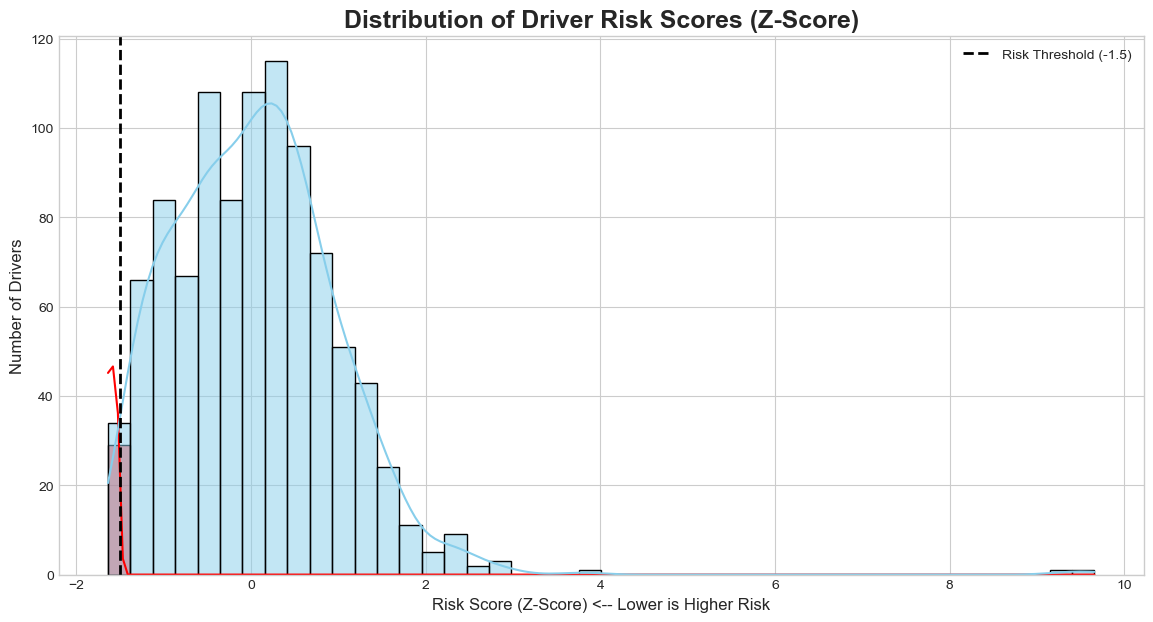

In [5]:
# ==============================================================================
# CELL 5: VISUALIZATION OF FLEET RISK SCORES
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

if 'final_summary_df' in locals():
    print("\n--- Cell 5: Visualizing Fleet Risk Scores ---")
    
    # Filter for only the vehicles that have a risk score (i.e., were healthy and active)
    plot_data = final_summary_df.dropna(subset=['risk_score_z'])

    if not plot_data.empty:
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(14, 7))

        sns.histplot(
            data=plot_data,
            x='risk_score_z',
            hue='final_risk_status',
            kde=True,
            palette={'High Risk': 'red', 'Normal': 'skyblue'},
            ax=ax
        )
        
        # Add a vertical line to show the risk threshold
        risk_threshold = CONFIG["risk_params"]["risk_z_score_threshold"]
        ax.axvline(risk_threshold, color='black', linestyle='--', linewidth=2, label=f'Risk Threshold ({risk_threshold})')
        
        ax.set_title('Distribution of Driver Risk Scores (Z-Score)', fontsize=18, weight='bold')
        ax.set_xlabel('Risk Score (Z-Score) <-- Lower is Higher Risk', fontsize=12)
        ax.set_ylabel('Number of Drivers', fontsize=12)
        ax.legend()
        
        plt.savefig(CONFIG["output_plot_path"], dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No risk scores were calculated, so no plot can be generated.")